# Initialization & Reusable Functions 

In [2]:
import pandas as pd
import sys
import re
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def parse_tpcc(resfile):
    try:
        tpcc = pd.read_csv(resfile, index_col=0)
    except Exception as e:
        raise Exception("could not parse tpcc {}: {}".format(resfile, e))
    return tpcc.iloc[1:-1].mean().rename(lambda x: "tpcc_" + x.strip()).rename(lambda x: re.match(r'(.*)\(.*', x).group(1))

def parse_perf(perfcsv):
    try:
        p = pd.read_csv(perfcsv,
                delimiter=";",
                skiprows=2,header=None,
                usecols=[0,2,3],
                names=["value", "event","sampletime"]
        )
    except Exception as e:
        raise Exception("could not parse perf {}: {}".format(perfcsv, e))
    p = p.set_index('event')
    # split of perf modifiers
    p.rename(mapper=lambda x: x.split(":")[0], axis='index', inplace=True)
    # return p['value'] / (p['sampletime']/1000) apparently this is not necessary
    return p['value']

def process_iteration(iterationdir):
    tpcc = parse_tpcc(Path(iterationdir) / 'result.csv')
    perf = parse_perf(Path(iterationdir) / 'perf.out')
    perf['l2_rqsts.all_data_refs_interp'] = perf['l2_rqsts.references'] - perf['l2_rqsts.all_code_rd']
    perf['l2_rqsts.data_misses_interp'] = perf['l2_rqsts.miss'] - perf['l2_rqsts.code_rd_miss']
    perf_per_throughput = perf / tpcc['tpcc_throughput']
    perf_per_throughput.rename(lambda r: r + "/tpcc_throughput", inplace=True)

    # topdown
    td = pd.Series()
    td['clocks'] = perf['cpu_clk_unhalted.thread']
    td['slots'] = perf['cpu_clk_unhalted.thread'] * 4
    td['frontend_bound'] = perf['idq_uops_not_delivered.core'] / td['slots']
    td['bad_speculation'] = (perf['uops_issued.any'] - perf['uops_retired.retire_slots'] + 4*perf['int_misc.recovery_cycles']) / td['slots']
    td['retiring'] = perf['uops_retired.retire_slots'] / td['slots']
    td['backend_bound'] = 1 - (td['frontend_bound'] + td['bad_speculation'] + td['retiring'])

    return pd.concat([tpcc, perf, perf_per_throughput, td])

COLS_TOPDOWN = ['frontend_bound', 'bad_speculation', 'backend_bound', 'retiring']
COLS_L2 = [ 'l2_rqsts.all_code_rd/tpcc_throughput', 'l2_rqsts.code_rd_miss/tpcc_throughput', 'l2_rqsts.miss/tpcc_throughput', 'l2_rqsts.references/tpcc_throughput'  ]
COLS_TPCC_PERF = ['tpcc_throughput', 'tpcc_avg_lat' ]

In [4]:
cache_producers = {} # key => func
cache = {} # key => func ret

In [5]:
def cached(key):
    def cached_decorator(func):
        cache_producers[key] = func
        return func
    return cached_decorator
def get_result(key):
    res = cache.get(key, None)
    if res is None:
        res = cache_producers[key]()
        cache[key] = res
    return res

In [6]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 4.5)
plt.rcParams['pgf.rcfonts'] = False
import seaborn as sns
sns.set()
sns.set(color_codes=True)
sns.set_palette("colorblind")
sns.set_style("whitegrid", {"legend.frameon":True})
sns.set_context('paper')

In [7]:
outputdir = Path('processed')
def savefig(filename, **kwargs):
    kwargs['bbox_inches'] = 'tight'
    plt.savefig(str(outputdir / "{}.{}".format(filename, "png")), dpi=300, **kwargs)
    plt.savefig(str(outputdir / "{}.{}".format(filename, "pgf")), **kwargs)
    plt.savefig(str(outputdir / "{}.{}".format(filename, "pdf")), **kwargs)
    

In [8]:
measure_results = Path('measure_results/dev')

In [8]:
@cached("3way")
def load_initial_comparison(measurements_dir=measure_results):
    dirs = []
    for i in Path(measurements_dir).iterdir():
        if not i.is_dir():
            raise Exception("unexpected file {}".format(i))
        if not i.suffix == '.broken':
            dirs.append(i)                     
    data = []
    index = []
    for d in dirs:
        def add_it(build, threads, iteration):
            it = process_iteration(d) # series
            it['build'] = build
            it['threads'] = threads
            it['iteration'] = iteration
            data.append(it)

        dname = os.path.basename(d)

        m = re.match(r'^devMAA_mine_t(\d+)_mwait(\d+)_maa(\d+)_(\d+)$', dname)
        if m:
            add_it("devMAA_mine_mwait{}_maa{}".format(m.group(2), m.group(3)), int(m.group(1)), int(m.group(4)))

        m = re.match(r'^mine_cinall_t(\d+)_mwait(\d+)_maa(\d+)_(\d+)$', dname)
        if m:
            add_it("mine_cinall_mwait{}_maa{}".format(m.group(2), m.group(3)), int(m.group(1)), int(m.group(4)))

        m = re.match(r'^mine_cinrunq3_t(\d+)_mwait(\d+)_maa(\d+)_(\d+)$', dname)
        if m:
            add_it("mine_cinrunq3_mwait{}_maa{}".format(m.group(2), m.group(3)), int(m.group(1)), int(m.group(4)))

        # mineFixed1C_t50_mwait0_maa5000000_2
        m = re.match(r'^(mineFixed\d+C)_t(\d+)_mwait(\d+)_(\d+)$', dname)
        if m:
            add_it("{}_mwait{}".format(m[1], m[3]), int(m[2]), int(m[4]))
            
        # upstream_t6_nospin1_ies2_5/perf.out
        m = re.match(r'^upstream_t(\d+)_nospin(\d+)_ies(\d+)_(\d+)$', dname)
        if m:
            threads = int(m.group(1))
            iteration = int(m.group(4))
            nospin = int(m.group(2))
            ies = int(m.group(3))
            add_it("upstream_nospin{}_ies{}".format(nospin, ies), threads, iteration)

        m = re.match(r'^upstreamFixed2C_t(\d+)_nospin(\d+)_ies(\d+)_(\d+)$', dname)
        if m:
            threads = int(m.group(1))
            nospin = int(m.group(2))
            ies = int(m.group(3))
            iteration = int(m.group(4))
            add_it("upstreamFixed2C_nospin{}_ies{}".format(nospin, ies), threads, iteration)
            
        # linuxvm_t50_0
        m = re.match(r'^linuxvm_t(\d+)_(\d+)', dname)
        if m:
            add_it("linuxvm", int(m.group(1)), int(m.group(2)))
            
            
    df = pd.DataFrame(data)
    cats = ['build', 'threads', 'iteration']
    for cat in cats:
        df[cat] = df[cat].astype('category', ordered=True)

    df.set_index(['build', 'threads', 'iteration'], inplace=True)

    return df
#cache['3way'] = None

In [9]:
@cached("wedidit")
def load_whole_system(measurements_dir=measure_results):
    dirs = []
    for i in Path(measurements_dir).iterdir():
        if not i.is_dir():
            raise Exception("unexpected file {}".format(i))
        if not i.suffix == '.broken':
            dirs.append(i)                     
    data = []
    index = []
    for d in dirs:
        def add_it(build, threads, mwait, iteration):
            it = process_iteration(d) # series
            it['build'] = build
            it['threads'] = threads
            it['mwait'] = mwait
            it['iteration'] = iteration
            data.append(it)

        dname = os.path.basename(d)
            
#         m = re.match(r'^devMAA_mine_t(\d+)_mwait(\d+)_maa(\d+)_(\d+)$', dname)
#         if m:
#             add_it("devMAA_mine_{}".format(m.group(3)), int(m.group(1)), int(m.group(2)), int(m.group(4)))
    
        # upstream_t6_nospin1_ies2_5/perf.out
        m = re.match(r'^upstream_t(\d+)_nospin(\d+)_ies(\d+)_(\d+)$', dname)
        if m:
            threads = int(m.group(1))
            nospin = int(m.group(2))
            ies = int(m.group(3))
            iteration = int(m.group(4))
            if nospin == 0 and ies == 1: # as close to upstream as possible
                add_it("upstream", threads, 0, iteration)
            if nospin == 1 and ies == 2: # as fair as possible TODO this with ies == 1 shows nicer cache miss results
                add_it("upstream", threads, 1, iteration)
                
        m = re.match(r'^upstreamFixed2C_t(\d+)_nospin(\d+)_ies(\d+)_(\d+)$', dname)
        if m:
            threads = int(m.group(1))
            nospin = int(m.group(2))
            ies = int(m.group(3))
            iteration = int(m.group(4))
            if nospin == 0 and ies == 0: # as close to upstream as possible
                add_it("upstreamFixed2C", threads, 0, iteration)
            if nospin == 0 and ies == 1: # ok to use halt for mwait because we don't compare topdown...
                add_it("upstreamFixed2C", threads, 1, iteration)

        # mineFixed1C_t50_mwait0_maa5000000_2
        m = re.match(r'^mineFixed2C_t(\d+)_mwait(\d+)_(\d+)$', dname)
        if m:
            add_it("mineFixedC2", int(m[1]), int(m[2]), int(m[3]))
            
                   
        m = re.match(r'^mine_cinrunq3_t(\d+)_mwait(\d+)_maa(\d+)_(\d+)$', dname)
        if m:
            add_it("mine_cinrunq3_{}".format(m.group(3)), int(m.group(1)), int(m.group(2)), int(m.group(4)))
    

    df = pd.DataFrame(data)
    cats = ['build', 'threads', 'mwait', 'iteration']
    for cat in cats:
        df[cat] = df[cat].astype('category', ordered=True)

    df.set_index(['build', 'threads', 'mwait', 'iteration'], inplace=True)

    return df
#cache['wedidit'] = None

In [10]:
@cached("cap")
def load_core_allocation_policy_evaluation(measurements_dir=measure_results):
    dirs = []
    for i in Path(measurements_dir).iterdir():
        if not i.is_dir():
            raise Exception("unexpected file {}".format(i))
        if not i.suffix == '.broken':
            dirs.append(i)                     
    data = []
    index = []
    for d in dirs:
        def add_it(build, threads, mwait, iteration):
            it = process_iteration(d) # series
            it['build'] = build
            it['threads'] = threads
            it['mwait'] = mwait
            it['iteration'] = iteration
            data.append(it)

        dname = os.path.basename(d)

        m = re.match(r'^devMAA_mine_t(\d+)_mwait(\d+)_maa(\d+)_(\d+)$', dname)
        if m:
            add_it("devMAA_mine_maa{}".format(m.group(3)), int(m.group(1)), int(m.group(2)), int(m.group(4)))

        m = re.match(r'^mine_cinall_t(\d+)_mwait(\d+)_maa(\d+)_(\d+)$', dname)
        if m:
            add_it("mine_cinall_maa{}".format(m.group(3)), int(m.group(1)), int(m.group(2)), int(m.group(4)))
        
        m = re.match(r'^mine_cinrunq3_t(\d+)_mwait(\d+)_maa(\d+)_(\d+)$', dname)
        if m:
            add_it("mine_cinrunq3_maa{}".format(m.group(3)), int(m.group(1)), int(m.group(2)), int(m.group(4)))
        
        # mineFixed1C_t50_mwait0_maa5000000_2
        m = re.match(r'^(mineFixed\d+C)_t(\d+)_mwait(\d+)_(\d+)$', dname)
        if m:
            add_it(m[1], int(m[2]), int(m[3]), int(m[4]))
            
    df = pd.DataFrame(data)
    cats = ['build', 'threads', 'mwait', 'iteration']
    for cat in cats:
        df[cat] = df[cat].astype('category', ordered=True)
    df.set_index(cats, inplace=True)
    return df


# Page Access Scanner

In [12]:
data = []
for d in Path('measure_results/pas').iterdir():
    m = re.match(r'^(.*)_pas(1000|10)_t12$', d.name)
    if not m:
        continue
    if not(m[1] == 'upstream' or m[1] == 'mine_mwait0'):
        continue
    ser = process_iteration(d)
    ser['Build'] = "Upstream OSv" if m[1] == "upstream" else "Our Solution"
    ser['PAS freq'] = m[2]
    data.append(ser)

df = pd.DataFrame(data)


df = df.set_index(['PAS freq', 'Build'])
df['L2 code miss rate'] = df['l2_rqsts.code_rd_miss'] / df['l2_rqsts.all_code_rd']
df = df[['tpcc_throughput', 'L2 code miss rate']]
df = df.rename({'tpcc_throughput':'throughput'}, axis=1)
df = df.unstack()
df = df.round(2)
df.to_latex('processed/pas_freq_effect.tex')
df

throughput              L2 code miss rate             
Build    Our Solution Upstream OSv      Our Solution Upstream OSv
PAS freq                                                         
10             643.69       549.50              0.39         0.75
1000           552.06       498.22              0.42         0.74

# MySQL Performance Analysis

We quote this in the section about stageifiying MySQL.
Both implementations include various spinners, thus the amount of frontend-boundedness may be even higher in reality, because tight spinning loops are not frontend-bound.

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:64: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


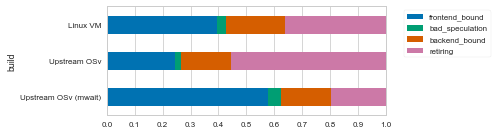

,frontend_bound,bad_speculation,backend_bound,retiring
build,,,,
Upstream OSv (mwait),0.578762,0.047074,0.176929,0.197236
Upstream OSv,0.245793,0.018494,0.181797,0.553915
Linux VM,0.396305,0.030662,0.212569,0.360464


In [11]:
df = get_result("3way")
sel = [
    ("upstream_nospin1_ies2", "Upstream OSv (mwait)"),
    ("upstream_nospin0_ies1", "Upstream OSv"),
#     ("mine_cinrunq3_mwait1_maa20000000", "Our Solution"),
    ("linuxvm", "Linux VM"),
]
q = 'threads == 1'
p = df.query(q).reset_index().set_index('build').loc[map(lambda x: x[0], sel)].rename(dict(sel)).reset_index()
p = p.loc[p['build'].isin(map(lambda x: x[1], sel))]
fig, ax = plt.subplots(figsize=(5,2))

p = p[["build", *COLS_TOPDOWN]].groupby('build').mean()
p = p.reset_index()
sorted_type = pd.Categorical(map(lambda x: x[1], sel), map(lambda x: x[1], sel))
p['build'] = p['build'].astype(sorted_type)
p = p.set_index('build').sort_index()

p.plot.barh(stacked=True, ax=ax,legend=False, xlim=(0,1), xticks=np.arange(0, 1.1, 0.1), grid=True)
# ax.set_title("Top-Down Top-Level Breakdown of MySQL under TPC-C")
ax.legend(bbox_to_anchor=(1.05, 1))
savefig('mysqlperf_topdown')
plt.show()

# p.to_latex('processed/3way_topdown_table.tex', column_format='r|cccc', bold_rows=True)
p.to_latex('processed/mysqlperf_topdown.tex', multirow=True)
p

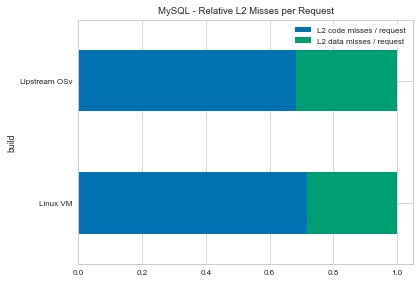

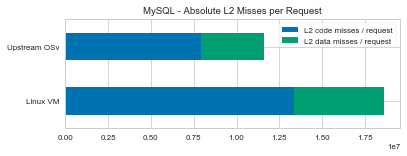

In [12]:
df = get_result("3way")
sel = [
    ("upstream_nospin1_ies2", "Upstream OSv"),
#     ("upstream_nospin0_ies1", "Upstream OSv (default)"),
#     ("mine_cinrunq3_mwait1_maa20000000", "Our Solution"),
    ("linuxvm", "Linux VM"),
]

q = 'threads == 20'
p = df.query(q).reset_index('threads', drop=True).reset_index()
p = p.loc[p['build'].isin(map(lambda x: x[0], sel))]
p = p.set_index('build').rename(dict(sel)).reset_index()

# p['L2 hit ratio'] = 1 - ( p['l2_rqsts.miss/tpcc_throughput'] / p['l2_rqsts.references/tpcc_throughput'])
# p['L2 code hit ratio'] = 1 - (p['l2_rqsts.code_rd_miss/tpcc_throughput'] / p['l2_rqsts.all_code_rd/tpcc_throughput'])
# p['l2_data_hitrate_interp'] = 1- (((p['l2_rqsts.miss/tpcc_throughput'] - p['l2_rqsts.code_rd_miss/tpcc_throughput'])
#                                   / (p['l2_rqsts.references/tpcc_throughput'] - p['l2_rqsts.all_code_rd/tpcc_throughput'])))

# p['L2 miss ratio'] = p['l2_rqsts.miss'] / p['l2_rqsts.references']
# p['L2 code miss ratio'] = p['l2_rqsts.code_rd_miss'] / p['l2_rqsts.all_code_rd']

# show relative situation
rel = p
rel['L2 code misses / request'] = rel['l2_rqsts.code_rd_miss/tpcc_throughput'] / rel['l2_rqsts.miss/tpcc_throughput']
rel['L2 data misses / request'] = 1 - rel['L2 code misses / request']
rel = rel[['build', 'iteration', 'L2 code misses / request', 'L2 data misses / request']]
rel = rel.set_index(['build', 'iteration'])
relmean = rel.groupby('build').mean()
relmean.plot.barh(use_index=True, legend=True, stacked=True)
plt.title("MySQL - Relative L2 Misses per Request")
plt.show()

# show absolute
fig, ax = plt.subplots(figsize=(6, 2))
a = p
a['L2 code misses / request'] = a['l2_rqsts.code_rd_miss/tpcc_throughput']
a['L2 data misses / request'] = a['l2_rqsts.miss/tpcc_throughput'] -a['l2_rqsts.code_rd_miss/tpcc_throughput']
a = a[['build', 'iteration', 'L2 code misses / request', 'L2 data misses / request']]
ag = a.set_index(['build', 'iteration']).groupby('build')
ag.mean().plot.barh(use_index=True, legend=True, stacked=True, ax=ax)
ax.set_ylabel("")
plt.title("MySQL - Absolute L2 Misses per Request")
savefig('mysqlperf_miss_distribution_abs')
plt.show()


# Introductory Firework: Ours / Upstream / Linux VM 

This section shows that our solution both outperforms upstream OSv and Linux using TPC-C performance metrics.
Additionally, it shows the performance advantage of OSv / library OS compared to Linux.

TODO: default our OSv to 50ms maa

Performance counters are enabled during the run => 1Hz interrupt every iteration. FIXME if possible

In [13]:
df = get_result("3way")
sel = [
#     ("linuxvm", "Linux VM"),
    ("upstream_nospin0_ies1","Upstream OSv (halt)"),
#     ("upstream_nospin1_ies2","Upstream OSv (MWAIT)"),
    ("upstream_nospin0_ies0","Upstream OSv (busy)"),
    # use the following to show that assignment_age has no impact
    ("mine_cinrunq3_mwait1_maa10000000","Our solution (10ms, mwait)"),
    ("mine_cinrunq3_mwait1_maa20000000","Our solution (20ms, mwait)"),
    ("mine_cinrunq3_mwait1_maa50000000","Our solution (50ms, mwait)"),
    ("mine_cinrunq3_mwait0_maa10000000","Our solution (10ms, busy)"),
    ("mine_cinrunq3_mwait0_maa20000000","Our solution (20ms, busy)"),
    ("mine_cinrunq3_mwait0_maa50000000","Our solution (50ms, busy)"),

#     "mine_cinall_mwait1_maa50000000":"3.2.3 Our solution (CAP cinall, MWAIT)",
#     "mine_cinall_mwait0_maa50000000":"3.2.4 Our solution (CAP cinall, busy)",

]
p = df.reset_index().set_index('build').loc[map(lambda x: x[0], sel)].rename(dict(sel)).reset_index()

# ["Linux VM", "Upstream OSv", "Our solution (MWAIT)", "Our solution (busy waiting)"]
sorted_type = pd.Categorical(p['build'], map(lambda x: x[1], sel))
p['build'] = p['build'].astype(sorted_type)
cache['fireworks'] = p

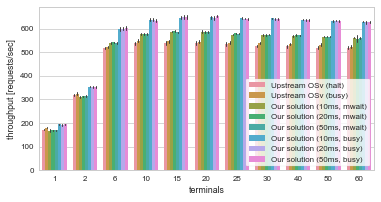

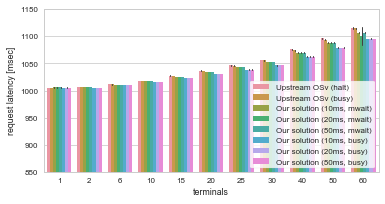

In [14]:
p = get_result('fireworks')
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(x='threads', y='tpcc_throughput', hue='build', ci='sd', errwidth=1, data=p)
# ax.set_title('TPC-C Throughput Over Varying Number of Terminals')
ax.set_xlabel('terminals')
ax.set_ylabel('throughput [requests/sec]')
ax.legend(loc='lower right')
savefig('3way_tpcc_throughput')
plt.show()

fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(x='threads', y='tpcc_avg_lat', hue='build', ci='sd', errwidth=1, data=p)
# ax.set_title('TPC-C request Latency Over Varying Number of Terminals')
ax.set_xlabel('terminals')
ax.set_ylabel('request latency [msec]')
ax.legend(loc='lower right')
ax.set_ylim(850, 1150)
savefig('3way_tpcc_reqlatency')
plt.show()

# only during development...
# fig, ax = plt.subplots()
# sns.barplot(x='threads', y='l2_rqsts.code_rd_miss/tpcc_throughput', hue='build', data=p)
# ax.set_title('L2 code misses over varying number of warehouses\n')
# ax.set_xlabel('terminals')
# ax.set_ylabel('L2 code misses / request')
# ax.legend(loc='lower right')
# plt.show()

### Speedup Due to Our Solution 

In [15]:
p = get_result('fireworks')
p = p[p['build'].map(lambda x: "20ms" in x or "Upstream" in x)]
p.loc['build'] = p['build'].astype(str)

p = p.groupby(['threads', 'build']).mean()[['tpcc_throughput']]
p.index = p.index.rename(['terminals', 'build'])
p = p.unstack()
p.columns = p.columns.droplevel()
p = p.apply(lambda c: c/p['Upstream OSv (halt)'])
p = p.unstack()
p.name = 'speedup'
p = p.unstack()
def highlight_max(s): # source https://pandas.pydata.org/pandas-docs/stable/style.html
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: olive' if v else '' for v in is_max]
p = p.round(2)
p.to_latex('processed/3way_tpcc_throughput_speedup.tex')
p.style.apply(highlight_max, axis=1)
# sns.barplot(x='threads', hue='build', data=p)
# p = p.columns.droplevel(0)
# p.unstack().div(p['upstream'])

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


terminals,1,2,6,10,15,20,25,30,40,50,60
build,,,,,,,,,,,
"Our solution (20ms, busy)",1.11,1.11,1.16,1.19,1.2,1.2,1.2,1.21,1.21,1.22,1.21
"Our solution (20ms, mwait)",0.98,0.98,1.05,1.08,1.09,1.09,1.08,1.09,1.09,1.09,1.07
Upstream OSv (busy),1.04,1.02,1.01,1.02,1.01,1.01,1.01,1.02,1.02,1.02,1.01
Upstream OSv (halt),1,1,1,1,1,1,1,1,1,1,1


#  Throughput gains are due to working set spreading

Verify by

* Significant drop in L2 instruction misses
* TopDown top-level breakdown
    * Shift from Front-End to Backend-Bound
    * Reduced mispredicted branches
* Excluding influence of removing OSv's scheduler

In [16]:
wsspreading_builds = [
    ("upstream","Upstream OSv"),
#     ("mineFixedC2", "Our solution (Fixed)"),
    ("mine_cinrunq3_20000000", "Our Solution"),
]

p = get_result("wedidit")
p = p.reset_index()
p = p[p['build'].isin(dict(wsspreading_builds).keys())]
p = p.set_index('build').rename(dict(wsspreading_builds)).reset_index()
sorted_type = pd.Categorical(p['build'], map(lambda x: x[1], wsspreading_builds))
p['build'] = p['build'].astype(sorted_type)
cache['wsspreading'] = p

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


In [17]:
p = get_result('wedidit')
p.head()

,,,,tpcc_throughput,tpcc_avg_lat,tpcc_min_lat,tpcc_25th_lat,tpcc_median_lat,tpcc_75th_lat,tpcc_90th_lat,tpcc_95th_lat,tpcc_99th_lat,tpcc_max_lat,...,l2_rqsts.miss/tpcc_throughput,l2_rqsts.references/tpcc_throughput,l2_rqsts.all_data_refs_interp/tpcc_throughput,l2_rqsts.data_misses_interp/tpcc_throughput,clocks,slots,frontend_bound,bad_speculation,retiring,backend_bound
build,threads,mwait,iteration,,,,,,,,,,,,,,,,,,,,,
upstream,25,1,4,513.638889,1048.574111,999.436833,1040.879444,1050.529389,1059.895444,1069.569667,1077.834722,1102.572667,1119.255167,...,1.150221e+07,1.584100e+07,5.386992e+06,3.659331e+06,1.419444e+11,5.677777e+11,0.530853,0.050048,0.217045,0.202055
upstreamFixed2C,40,0,7,521.611111,1076.608389,996.385111,1068.338111,1079.842611,1091.466667,1106.999056,1128.273611,1165.244556,1181.904833,...,8.686073e+06,1.646430e+07,7.183312e+06,4.447953e+06,5.674167e+11,2.269667e+12,0.105673,0.012211,0.691588,0.190528
mine_cinrunq3_50000000,1,0,0,192.916667,1005.116444,998.973333,1001.694667,1003.194889,1008.270000,1010.908722,1012.470278,1015.374333,1020.186389,...,6.331750e+06,1.453316e+07,6.090272e+06,3.450895e+06,5.605753e+11,2.242301e+12,0.030698,0.003665,0.310769,0.654868
mine_cinrunq3_20000000,20,0,0,653.333333,1030.520556,997.508833,1023.895944,1030.931389,1037.893500,1045.210278,1052.251222,1077.836611,1100.652056,...,6.750404e+06,1.406700e+07,6.572237e+06,3.782760e+06,5.662292e+11,2.264917e+12,0.081796,0.011906,0.301865,0.604433
mine_cinrunq3_10000000,20,0,2,644.388889,1030.888056,998.800944,1024.511000,1031.627000,1038.557389,1046.026722,1052.064500,1073.015000,1096.787722,...,6.699891e+06,1.418704e+07,6.644089e+06,3.751060e+06,5.654763e+11,2.261905e+12,0.082369,0.011755,0.301929,0.603946


## L2 Metrics

In [18]:
# cache['3way'] = None
p = get_result('3way')
# print(list(p.reset_index()['build'].unique()))

sel = [
    
    # Out-of-place, but interesiting: compare fixed Stage-API implementation
#     ("upstreamFixed2C_nospin0_ies2","Stage-API Upstream OSv (fixed, mwait)"),
#     ("upstreamFixed2C_nospin0_ies0","Stage-API Upstream OSv (fixed, busy)"),
#     ("mineFixed2C_mwait0", "Our Solution (fixed, busy"),
#     ("mineFixed2C_mwait1", "Our Solution (fixed, mwait)"),
    
    # Compare the following two to see the influence of HALT vs MWAIT
    # => negligible, use MWAIT to be fair
#     ('upstream_nospin0_ies1','Upstream OSv (0, 1)'),
#     ('upstream_nospin0_ies2','Upstream OSv (0, 2)'),

    # We choose to compare with MWAIT
    ('upstream_nospin0_ies0','Upstream OSv (busy)'),
    ('upstream_nospin1_ies2','Upstream OSv (mwait)'),
    ('upstream_nospin0_ies1','Upstream OSv (halt)'),
    ("mine_cinrunq3_mwait1_maa20000000","Our Solution (mwait)"),
    ("mine_cinrunq3_mwait0_maa20000000","Our Solution (busy)"),
]

p = p.reset_index()
p = p[p['build'].isin(list(map(lambda x: x[0], sel)))]
p = p.replace({'build':dict(sel)})

# pre-process some metircs
p['L2 code references / request'] = p['l2_rqsts.all_code_rd/tpcc_throughput']
p['L2 data references / request'] = p['l2_rqsts.references/tpcc_throughput'] - p['l2_rqsts.all_code_rd/tpcc_throughput']
p['L2 code misses / request'] = p['l2_rqsts.code_rd_miss/tpcc_throughput']
p['L2 data misses / request'] = p['l2_rqsts.miss/tpcc_throughput'] -p['l2_rqsts.code_rd_miss/tpcc_throughput']

cache['wsspread_l2'] = p

###  Take a look at Std Deviations

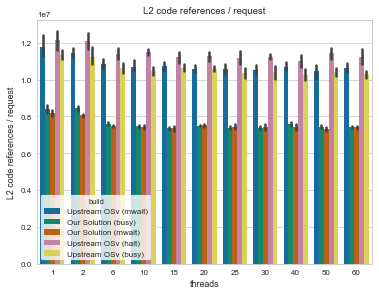

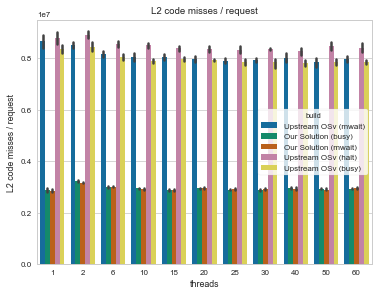

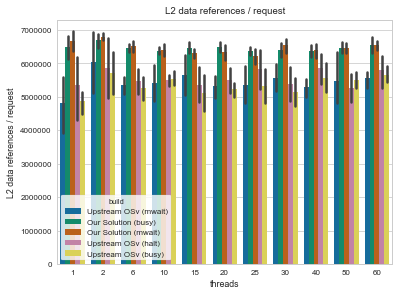

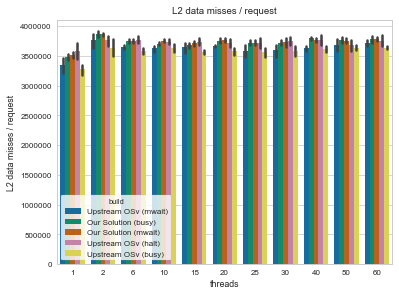

In [19]:
p = get_result('wsspread_l2')

def showmetric(col):
    ax = sns.barplot(x='threads', y=col, hue='build', data=p)
    ax.set_title(col)
#     plt.subplots_adjust(top=0.85)
#     grid.set_xlabels('TPC-C terminals')
#     grid.axes[0, 1].set_ylim(0,1)
    plt.show()
    # ax.set_ylabel('L2 code misses / request')
    # ax.legend(loc='lower left')

showmetric('L2 code references / request'); plt.show()
showmetric('L2 code misses / request'); plt.show()
showmetric('L2 data references / request'); plt.show()
showmetric('L2 data misses / request'); plt.show()

Conclusion: Code misses are the metric that changed, data misses only little increased.

###  Summary in Thesis: We reduce L2 code misses

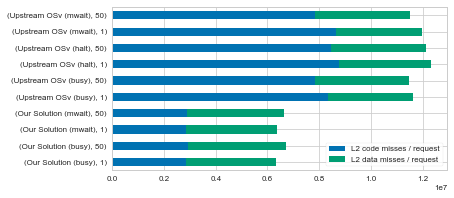

,L2 code misses / request,L2 data misses / request
build,,
Our Solution (busy),0.35,1.02
Our Solution (mwait),0.34,1.02
Upstream OSv (busy),0.93,0.99
Upstream OSv (halt),1.00,1.00
Upstream OSv (mwait),0.93,1.00


In [20]:
p = get_result('wsspread_l2')
fig, ax = plt.subplots(figsize=(6, 3))
p = p[(p['threads'] == 1) | (p['threads'] == 50)]
p = p.set_index(['build', 'threads'])
p = p[['L2 code misses / request', 'L2 data misses / request']]
p = p.groupby(['build', 'threads']).mean().sort_index()
p.plot.barh(stacked=True, ax=ax)
ax.set_ylabel('')
# ax.set_title("MySQL - L2 cache metrics")
savefig("wsspread_l2")
plt.show()

s = p
# Pick least favorable thread count to us
s = s.query('threads == 50').reset_index('threads', drop=True)
s = s.transpose()
baseline = s['Upstream OSv (halt)']
speedup = s.div(baseline, axis=0).transpose().round(2)
speedup.to_latex('processed/wsspread_l2_speedup.tex')
speedup

## Top-Down Metrics

In [ ]:
p = get_result('3way')
# print(list(p.reset_index()['build'].unique()))

sel = [
    # Remember: must use mwait for topdown
    ('upstream_nospin1_ies2','Upstream OSv (mwait)'),
    ("mine_cinrunq3_mwait1_maa20000000","Our Solution (mwait)"),
    
    # Comment-in for confirmation that Upstream stage API partitions as intended
#     ('upstreamFixed2C_nospin1_ies2','Upstream OSv (fixed, mwait)'),
]

p = p.reset_index()
p = p[p['build'].isin(list(map(lambda x: x[0], sel)))]
p = p.replace({'build':dict(sel)})

p = p[['build', 'threads', 'iteration', *COLS_TOPDOWN]]
p = p[(p['threads'].isin([1, 50]))]
p['threads'] = p['threads'].astype(int)

p = p.rename({'threads':'terminals'}, axis=1)

p = p.groupby(['build', 'terminals']).mean()

fig, ax = plt.subplots(figsize=(5, 2))
p.plot.barh(stacked=True, ax=ax,legend=False, xlim=(0,1), xticks=np.arange(0, 1.1, 0.1), grid=True)
# ax.set_title("MySQL - Top-Down Top-Level Breakdown")
ax.legend(bbox_to_anchor=(1.05, 1))
savefig("wsspread_topdown")
plt.show()

p = p.round(2)
p.to_latex('processed/wsspread_topdown.tex')
p

## Influence of Removing The Scheduler

**TODO**

* Run upstream and ours with single core (ours with disabled thread migration == roundrobin)
* Measure TPC-C throughput

# Thread Migration Mechanisms Are Responsible For The Speedup

Maybe this is equivalent / better than the 'Influence of Removing The Scheduler' section above?

## Micro-Benchmark: How much faster are we

** TODO **

* Upstream OSv vs Ours (vs Linux VM, if there is time)
* Use hopper benchmark, libfakeosv with sched_setaffinity, 1 core per stage
* Find a way to show the overhead of hypervisor / virtualized interrupts
    * Linuxvm vs Osv doesn't show that
    * => Maybe run microbenchmark on bare metal and Linux? best effort...

In [22]:
# sudo ./runosvpinned.sh ~/osv/build/last/usr.img 2-7 ' --idle_mwait=0 -- /cs_microbench.so --nobmr --bench hopper 3 20 400 4400 1000000'
# sudo ./runosvpinned.sh ~/osv_upstream/build/last/usr.img 2-7 '--idle_nospin=0 --idle_empty_strategy=0 -- /cs_microbench.so --nobmr --bench hopper 3 55 1000 12000  1000000'

def parse_hopper_output(hopper_output):
    import io
    df = pd.read_csv(hopper_output, delim_whitespace=True, skiprows=5,
                      names=["start", "end", "count"])
    with open(hopper_output) as f:
        for row in f:
            m = re.match("^mean\s+([0-9\.]+)", row)
            if m:
                return df, float(m[1])
    raise Exception("could not find mean")

hopper_bucket_size = 200
hopper_records = [
        ("Our Solution", "busy", "hopper_mine_mwait0"),
        ("Our Solution", "mwait", "hopper_mine_mwait1"),
        ("Upstream", "mwait-nospin", "hopper_upstream_nospin1_ies2"),
        ("Upstream", "mwait-prespin", "hopper_upstream_nospin0_ies2"),
        ("Upstream", "busy", "hopper_upstream_nospin0_ies0"),
        ("Upstream", "halt-prespin", "hopper_upstream_nospin0_ies1"),
        ("Upstream", "halt-nospin", "hopper_upstream_nospin1_ies1"),
    ]
@cached('hopper_hist')
def build_hopper_hist():
    data = []
    means = []
    for n in hopper_records:
        h, mean = parse_hopper_output(Path('measure_results/hopper') / n[2])
        for i in (h['end'] - h['start']) == hopper_bucket_size:
            if not i:
                raise Exception("bucket size != {}".format(hopper_bucket_size))
        means.append((n, mean))
        h['build'] = n[0]
        h['idle_strategy'] = n[1]
        h = h.drop('end', axis=1)
        h = h.set_index(['build', 'idle_strategy', 'start'])
        data.append(h)

    return pd.concat(data), means
cache['hopper_hist'] = None

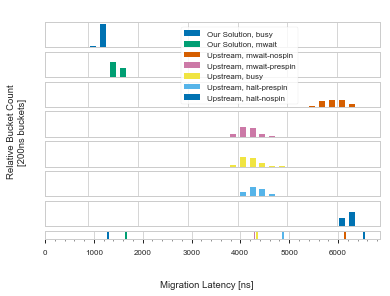

[(('Our Solution', 'busy', 'hopper_mine_mwait0'), 1295.87), (('Our Solution', 'mwait', 'hopper_mine_mwait1'), 1658.45), (('Upstream', 'mwait-nospin', 'hopper_upstream_nospin1_ies2'), 6146.05), (('Upstream', 'mwait-prespin', 'hopper_upstream_nospin0_ies2'), 4289.39), (('Upstream', 'busy', 'hopper_upstream_nospin0_ies0'), 4339.67), (('Upstream', 'halt-prespin', 'hopper_upstream_nospin0_ies1'), 4864.53), (('Upstream', 'halt-nospin', 'hopper_upstream_nospin1_ies1'), 6528.9)]


idle_strategy         busy            halt-nospin               halt-prespin  \
build         Our Solution  Upstream Our Solution      Upstream Our Solution   
start                                                                          
400.0             0.003870  0.000000          NaN  0.000000e+00          NaN   
600.0             0.003871  0.000000          NaN  0.000000e+00          NaN   
800.0             0.003871  0.000000          NaN  0.000000e+00          NaN   
1000.0            0.030080  0.000000          NaN  0.000000e+00          NaN   
1200.0            0.977261  0.000000          NaN  0.000000e+00          NaN   
1400.0            0.996268  0.000000          NaN  0.000000e+00          NaN   
1600.0            0.997671  0.000000          NaN  0.000000e+00          NaN   
1800.0            0.997742  0.000000          NaN  0.000000e+00          NaN   
2000.0            0.997822  0.000000          NaN  0.000000e+00          NaN   
2200.0            0.997910  0.000000          NaN  0.000000e+00          NaN   
2400.0            0.997962  0.000000          NaN  0.000000e+00          NaN   
2600.0            0.997992  0.000000          NaN  0.000000e+00          NaN   
2800.0            0.998008  0.000001          NaN  5.002504e-07          NaN   
3000.0            0.998027  0.000001          NaN  1.000501e-06          NaN   
3200.0            0.998044  0.000001          NaN  2.001002e-06          NaN   
3400.0            0.998060  0.000002          NaN  2.001002e-06          NaN   
3600.0            0.998076  0.000034          NaN  2.001002e-06          NaN   
3800.0            0.998094  0.053897          NaN  2.001002e-06          NaN   
4000.0            0.998107  0.450620          NaN  2.001002e-06          NaN   
4200.0            1.000000  0.817760          NaN  2.001002e-06          NaN   
4400.0            1.000000  0.963728          NaN  2.001002e-06          NaN   
4600.0            1.000000  0.991044          NaN  2.001002e-06          NaN   
4800.0            1.000000  0.993340          NaN  3.001502e-06          NaN   
5000.0            1.000000  0.993654          NaN  3.501753e-06          NaN   
5200.0            1.000000  0.993817          NaN  5.002504e-06          NaN   
5400.0            1.000000  0.993947          NaN  9.324667e-04          NaN   
5600.0            1.000000  0.994032          NaN  6.641324e-03          NaN   
5800.0            1.000000  0.994109          NaN  2.685844e-02          NaN   
6000.0            1.000000  0.994161          NaN  3.246165e-01          NaN   
6200.0            1.000000  0.994206          NaN  8.232380e-01          NaN   
6400.0            1.000000  0.994243          NaN  9.547724e-01          NaN   
6600.0            1.000000  0.994267          NaN  9.638744e-01          NaN   
6800.0            1.000000  0.994299          NaN  9.652681e-01          NaN   
7000.0            1.000000  0.994328          NaN  9.656928e-01          NaN   
7200.0            1.000000  0.994384          NaN  9.668954e-01          NaN   
7400.0            1.000000  0.994467          NaN  9.713462e-01          NaN   
7600.0            1.000000  0.994536          NaN  9.768294e-01          NaN   
7800.0            1.000000  0.994601          NaN  9.781806e-01          NaN   
8000.0            1.000000  0.994659          NaN  9.788289e-01          NaN   
8200.0            1.000000  0.994717          NaN  9.791526e-01          NaN   
8400.0            1.000000  0.994780          NaN  9.792381e-01          NaN   
8600.0            1.000000  0.994838          NaN  9.800800e-01          NaN   
8800.0            1.000000  0.994914          NaN  9.826253e-01          NaN   
9000.0            1.000000  0.995010          NaN  9.833016e-01          NaN   
9200.0            1.000000  0.995110          NaN  9.834852e-01          NaN   
9400.0            1.000000  0.995158          NaN  9.838489e-01          NaN   
9600.0            1.000000  0.995198          NaN  9.854907e-01          NaN   


In [23]:
df, means = get_result('hopper_hist')
bystart = df.reset_index().set_index(['start', 'build', 'idle_strategy']).unstack().unstack().fillna(0)
rel = bystart.cumsum() / bystart.sum()
rel.columns = rel.columns.droplevel(0)
# bystart[(rel < 0.986).all(axis=1)]
f = (rel <= 0.95).any(axis=1)
df = bystart[f].stack().stack()

import matplotlib.ticker as ticker
df = df.reset_index()
fig, ax = plt.subplots(nrows=len(means) + 1, figsize=(6,4), sharex=True, sharey=True,
                       gridspec_kw={'height_ratios':np.append(np.repeat(0.75, len(means)), 0.25)})
for i, (build, idle, filename) in enumerate(hopper_records):
    p = df[(df['build'] == build) & (df['idle_strategy'] == idle)]
    p = p[['start', 'count']]
    pr = p / p.sum()
    width = 120
    dist = 0
#     assert((i+1)*(width+dist) <= hopper_bucket_size)
    offset = (hopper_bucket_size - width) / 2
    label = "{}, {}".format(build, idle)
#     ax[i].bar(p['start'] + (width+dist)*i, pr['count'], color="C{}".format(i), alpha=1, width=width, align='edge', label=label)
    ax[i].bar(p['start'] + offset, pr['count'], color="C{}".format(i), alpha=1, width=width , align='edge', label=label)
    
for (build, idle, filename), mean in means:
    label = "{}, {}".format(build, idle)
    ax[len(means)].bar(mean, 1, width=40)
    ax[len(means)].set_yticks([])    

# ax[len(means)].set_xlabel("Migration Latency [ns]")

legend_entries = list(map(lambda x: "{}, {}".format(x[0][0], x[0][1]), means))
fig.legend(legend_entries, loc='right', bbox_to_anchor=(0.7, 0.8))

minors = np.arange(0, p['start'].max() + 4* hopper_bucket_size, hopper_bucket_size)
ax[len(means)].set_xticks(minors, minor=True)
ax[len(means)].tick_params(axis='x', which='minor', direction='out', length=2, width=0.5)
ax[len(means)].tick_params(axis='x', which='major', direction='out', length=4, width=1)

fig.text(0.06, 0.5, "Relative Bucket Count\n[{}ns buckets]".format(hopper_bucket_size), ha='center', va='center', rotation='vertical')
fig.text(0.5, -0.04, 'Migration Latency [ns]', ha='center')

savefig('threadmig_hopper_hists')
plt.show()

print(means)
rel

## Real-World Effect:  Implement Stage API in Upstream OSv's

**TODO**

* Fixed Core Allocation, 2C per stage
* Stage Switching based on thread::pin
* Do not implement Work-Conserving Wake-Ups
    * The timer + thread-state related refactorings are our work!
    * Threads will thus wakw up on the CPU they went to sleep on
    * This is where we should see the benefits of our solution
* Run with single terminal shows influence of fast thread migration vs IPI-based
* Run with many terminals shows _additional_ influence of work-conserving wake-ups
* If there is time, add a tracepoint for measuring the time that is spent in idle thread / use existing tracepoint

#### Throughput Comparison

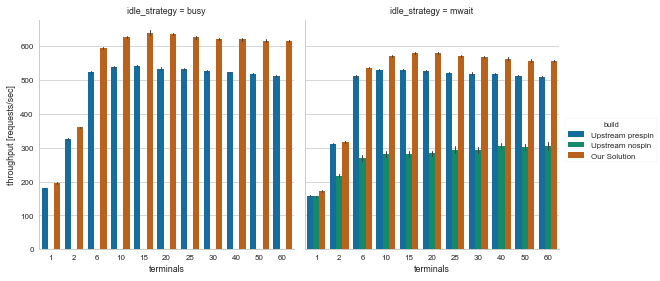

build         Our Solution               Upstream nospin                \
terminals               1      15     50              1      15     50   
idle_strategy                                                            
busy                 195.0  640.0  617.0             NaN    NaN    NaN   
mwait                172.0  581.0  558.0           157.0  282.0  302.0   

build         Upstream prespin                
terminals                   1      15     50  
idle_strategy                                 
busy                     180.0  543.0  518.0  
mwait                    159.0  529.0  513.0

In [24]:
#cache['3way'] = None
p = get_result('3way')
# print(list(p.reset_index()['build'].unique()))

sel = [
    
    # Out-of-place, but interesiting: compare fixed Stage-API implementation
     ("upstreamFixed2C_nospin1_ies2","Upstream nospin (mwait)"),
     ("upstreamFixed2C_nospin0_ies2","Upstream prespin (mwait)"),
    ("upstreamFixed2C_nospin0_ies0","Upstream prespin (busy)"),
     ("mineFixed2C_mwait1", "Our Solution (mwait)"),
     ("mineFixed2C_mwait0", "Our Solution (busy)"),
#     ("mine_cinrunq3_mwait0_maa20000000","Our solution (20ms, busy)"),
]

p = p.reset_index()
p = p[p['build'].isin(list(map(lambda x: x[0], sel)))]
p = p.replace({'build':dict(sel)})
p = p.rename({'threads':'terminals'}, axis=1)
names = list(map(lambda x: x[1], sel))
p['idle_strategy'] = p['build'].str.extract("^[^\(]+\s+\((?P<idle_strategy>[^\)]*)", expand=True)
p['build'] = p['build'].str.extract("^(?P<build>[^\(]+)\s+\(.*", expand=True)
# fig, ax = plt.subplots(figsize=(6, 3))

g = sns.factorplot(legend=True, size=4, kind='bar', col='idle_strategy', errwidth=1,
                   x='terminals', y='tpcc_throughput', hue='build', ci='sd', data=p)
# ax = sns.barplot(x='threads', y='tpcc_throughput', hue='build', ci='sd', errwidth=1, data=p)
# ax.set_title('TPC-C Throughput Over Varying Number of Terminals')
g.axes[0, 0].set_xlabel('terminals')
g.axes[0, 0].set_ylabel('throughput [requests/sec]')
# ax.set_xlabel('terminals')
# ax.set_ylabel('throughput [requests/sec]')
# ax.legend(title="Build, Core Assignment, Idle Strategy", loc='lower center')

# g.fig.legend(sorted_type.categories, loc='lower center', ncol=2)
savefig('threadmig_tpcc_throughput')
plt.show()

results = p.groupby(['build', 'terminals', 'idle_strategy']).mean()[['tpcc_throughput']].unstack()
# ours = results.query('build == "Our Solution"').reset_index('build', drop=True)
# upstream = results.query('build == "Upstream ThreadMig"').reset_index('build', drop=True)
# ours / upstream
table = results.query('terminals in [1,15,50]').transpose().round(0)
table.index= table.index.droplevel(0)
tl = table.to_latex()
tl = tl.replace("NaN", "N/A")
with open('processed/threadmig_tpcc_speedup.tex', 'w') as f:
    f.write(tl)
table

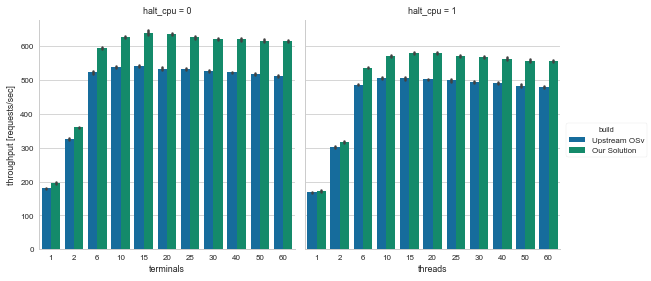

Speedup of speedup
 threads
1     1.058788
2     1.048688
6     1.029484
10    1.031396
15    1.027223
20    1.032072
25    1.028101
30    1.030815
40    1.037022
50    1.032140
60    1.036778
dtype: float64


threads,1,2,6,10,15,20,25,30,40,50,60
halt_cpu,,,,,,,,,,,
0,1.085953,1.101879,1.137538,1.165057,1.180408,1.192168,1.176102,1.179265,1.186212,1.191489,1.204048
1,1.025656,1.050722,1.104959,1.129592,1.149125,1.155121,1.143955,1.144012,1.143863,1.154386,1.161337


In [25]:
#cache['wedidit'] = None
wsspreading_builds = [
    ("upstreamFixed2C","Upstream OSv"),
    ("mineFixedC2", "Our Solution"),
]

p = get_result("wedidit")
p = p.reset_index()
p = p[p['build'].isin(dict(wsspreading_builds).keys())]
sorted_type = pd.Categorical(p['build'], map(lambda x: x[1], wsspreading_builds))
p['build'] = p['build'].replace(dict(wsspreading_builds)).astype(sorted_type)
p = p.rename({'mwait':'halt_cpu'}, axis=1)

# fig, ax = plt.subplots(figsize=(6, 3))
g = sns.factorplot(legend=True, kind='bar',
                   col='halt_cpu', x='threads', y='tpcc_throughput', hue='build', ci='sd', data=p)
# ax.set_title('TPC-C Throughput Over Varying Number of Terminals')
g.axes[0, 0].set_xlabel('terminals')
g.axes[0, 0].set_ylabel('throughput [requests/sec]')
# g.fig.legend(sorted_type.categories, loc='lower center', ncol=2)
savefig('threadmig_tpcc_throughput_old')
plt.show()

compare = p
means = compare.groupby(['build', 'halt_cpu', 'threads']).mean()[['tpcc_throughput']]
means = means.reset_index('build')
upstream = means[means['build'] == 'Upstream OSv'].drop('build', axis=1)
ours = means[means['build'] == 'Our Solution'].drop('build', axis=1)
speedup = (ours / upstream).unstack()
speedup.columns = speedup.columns.droplevel(0)
speedup.round(2).to_latex('processed/threadmig_tpcc_tpcc_speedup_old.tex')
print("Speedup of speedup\n", speedup.iloc[0] / speedup.iloc[1])
speedup

#### Idle Traces (inconclusive)

In [26]:
def parse_idle_ret_trace(tracefile):
    # 0xffff800001bcc040 idle3            3        16.050700282 sched_idle_ret       
    r = re.compile(r'(?P<thread>0x[0-9a-f]+) \S+\s+(?P<cpu>\d+)\s+(?P<sec>[\d]+).(?P<nsec>\d{9}) (?P<event>\S+)')
    
    data = []
    with open(tracefile) as f:
        for line in f:
            m = r.match(line)
            if not m:
                continue
            data.append({
                'thread':m['thread'],
                'core':int(m['cpu']),
                'time':int(m['sec']) * 10**9 + int(m['nsec']),
                'event':m['event'],
            })
    df = pd.DataFrame(data)
    return df

def parse_idle_time_trace(tracefile):
    # 0xffff800001bce040 idle3            3        15.306333034 sched_idle_time      time=56216
    r = re.compile(r'(?P<thread>0x[0-9a-f]+) \S+\s+(?P<cpu>\d+)\s+(?P<sec>[\d]+).(?P<nsec>\d{9}) sched_idle_time\s+ time=(?P<idle_time>\d+)')
    
    data = []
    with open(tracefile) as f:
        for line in f:
            m = r.match(line)
            if not m:
                continue
            data.append({
                'core':int(m['cpu']),
                'time':int(m['sec']) * 10**9 + int(m['nsec']),
                'idle_time':int(m['idle_time'])
            })
    df = pd.DataFrame(data)
    return df

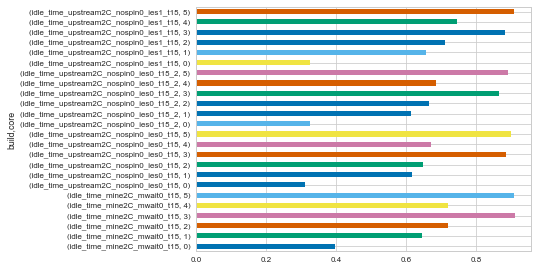

In [27]:
respath = Path('measure_results/threadmigtrace')
data = []
for d in respath.iterdir():
    if not d.name.startswith('idle_time'):
        continue
    df = parse_idle_time_trace(d)
    coretype = pd.Categorical(sorted(df['core'].unique()), ordered=True)
    df['core'] = df['core'].astype(coretype)
    df['build'] = d.name
    df = df.set_index(['build', 'core', 'time'])
    data.append(df)
df = pd.concat(data)

maxtimes = df.reset_index('time')['time'].groupby(['build', 'core']).max()
mintimes = df.reset_index('time')['time'].groupby(['build', 'core']).min()
length = (maxtimes - mintimes)
length
idle = df.groupby(['build', 'core']).sum()['idle_time']
q = idle / length
q.plot.barh(stacked=True)

# Evaluation of the Core Allocation Policy

## CAP: Jitter (irrelevant since cinrunq3 fixed it)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


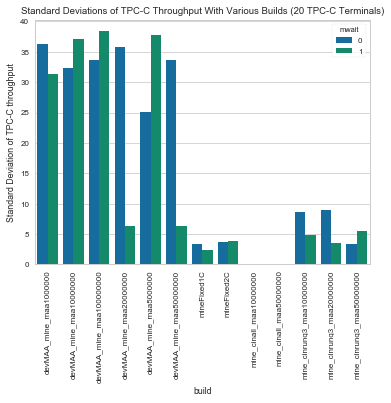

In [28]:
df = get_result("cap")
p = df.query('threads == 20').groupby(['build', 'mwait']).std()
# p = p.reset_index().set_index('build').loc[builds].reset_index()
p = p.reset_index()
# fig, ax = plt.subplots(ncols=2)
g = sns.barplot(x='build', y='tpcc_throughput', hue='mwait', data=p)
labels = g.get_xticklabels()
g.set_xticklabels(labels, rotation=90)
g.set_ylabel('Standard Deviation of TPC-C throughput')
g.set_title('Standard Deviations of TPC-C Throughput With Various Builds (20 TPC-C Terminals)')
#sns.barplot(x='threads', y='tpcc_throughput', hue='build', ci=None, data=p)
# ax.set_title('TPC-C Throughput with varying warehouses and max_assignment_age\n' + q)
# ax.set_xlabel('TPC-C warehouses')
# ax.set_ylabel('requests / second')
plt.show()

The difference in standard deviation with fixed core allocation is very low.

The difference in standard deviation of maa=100000000 and maa=50000000 are way more significant than those for other max assignment ages.

Let's see what happens when we vary threads.

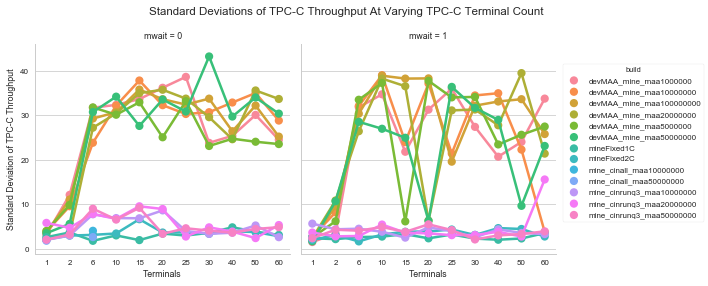

In [29]:
df = get_result("cap")
p = df.reset_index()
group = ['build', 'threads', 'mwait']
p = p.set_index(group).groupby(group).std().reset_index()

facetgrid = sns.factorplot(x='threads', y='tpcc_throughput', hue='build', col='mwait', kind='point', data=p)
facetgrid.set_ylabels('Standard Deviation of TPC-C Throughput')
facetgrid.set_xlabels('Terminals')
plt.subplots_adjust(top=0.85)
facetgrid.fig.suptitle('Standard Deviations of TPC-C Throughput At Varying TPC-C Terminal Count')
plt.show()

# # Other perspective, same situation
# sns.stripplot(x='threads', y='tpcc_throughput', hue='build', data=p)
# plt.show()

OK, this is way more useful than the other plot.

**The qualitative takeaway from this figure is that jitter is significantly influenced by**

* MWAIT vs busy-waiting seems to actually affect jitter significantly
* The number of terminals
    * Pretty consistent from 1 -- 6 (presumably, TODO more data)
    * Afterward jitter could be due to TPC-C


# CAP

In [30]:
import re

def parse_update_assignment_trace(tracefile, stages, cpus):
    """ parse trace of file containing trace of sched_stage_update_assignment tracepoint
    tracefile must be generated with ``scripts/trace.py``
    Returns a data frame that is very denormalized. Sensible view are:
    * time, core, core_stage
    * time, stage, stage_load
    
    """
    
    # 0xffff80002294c040 >/usr/bin/mysql  5        20.845687054 sched_stage_update_assignment cpu=5 ns=589 c0=57 c1=37 c2=54 c3=0 c4=0 c5=0 c6=0 c7=0 s0=c s1=12 s2=21 s3=0
    linere = re.compile(r'.* (?P<time>[\d\.]+) sched_stage_update_assignment cpu=\d+ ns=(?P<runtime>\d+) (?P<stageload>(c\d+=\d+ *)+)(?P<assignments>(s\d+=[0-9a-f]+ *)+).*$')
    are = re.compile(r's\d=([0-9a-f]+)\s*')
    slre = re.compile(r'c\d=(\d+)\s*')
    
    lines = []
    for line in open(tracefile):
        m_l = linere.match(line)
        if not m_l:
            continue
        #print(line)
        ldf = pd.Series(dtype='uint32')
        stageload_sum = 0
        for i in m_l['stageload'].rstrip().split(" "):
            key, val = i.split("=")
            ldf[key] = int(val)
            stageload_sum += int(val)
        ldf['csum'] = stageload_sum

        for i in m_l['assignments'].rstrip().split(" "):
            key, val = i.split("=")
            ldf[key] = int(val, 16)

        # derive assignment (ca)
        for c in range(0, cpus):
            stage = -1
            for si in range(0, stages):
                if ldf["s" + str(si)] & 1<<c:
                    if stage != -1:
                        raise Exception("duplicate assignment of cpu {} found another in stage {}".format(c, s))
                    stage = si
            ldf['ca'+str(c)] = stage
                    
        for s in range(0, stages):
            for c in range(0, cpus):
                lines.append({
                    "time": float(m_l['time'])*(10**6),
                    "stage": s,
                    "core": c,
                    "core_stage": ldf["ca{}".format(c)],
                    "stage_load": float(ldf["c{}".format(s)]),
                    "runtime": float(m_l['runtime']),
                })


    df = pd.DataFrame(lines)
    return df

In [31]:

@cached('assignment_traces')
def load_assignment_traces():
    dfs = []
    tracedir = Path('measure_results/devtrace')
    for d in tracedir.iterdir():    
        dname = d.name

        m = re.match(r'^([^_]+)_t(\d+)_maa(\d+)$', dname)
        if m and m[1] == "cinrunq3" and m[3] == '20000000':
            df = parse_update_assignment_trace(d, 3, 6)
            df['maa'] = int(m[3])
            df['threads'] = int(m[2])
            df['build'] = m[1] 
            dfs.append(df)

    return pd.concat(dfs, join='inner')

#cache['assignment_traces'] = None

In [32]:
trace_begin = 8*1000
trace_end = 9*1000

#### CAP Runtime

In [33]:
df = get_result('assignment_traces')
# get perspective that we need: runtime
t = df.groupby(['build', 'maa', 'threads', 'time']).first().reset_index(['threads', 'time'])
# limit to what we want to present
t = t.query('build == "cinrunq3" & maa == 20000000 & threads in [1,6,12] ').reset_index(['build', 'maa'], drop=True)
t = t.groupby('threads')['runtime']
p = pd.DataFrame({"mean runtime [ns]": t.mean(), "stddev runtime [ns]": t.std()})
# should not depend on t
perit = p['mean runtime [ns]'] / 324
p.index = p.index.rename('terminals')
p['Runtime per Iteration at C=6 S=3 => 324 Iterations'] = perit
p['Interp Runtime at C=32 S=8 => 65536 Iterations'] = 65536 * perit
p.take([0, 1], axis=1).to_latex('processed/cap_runtime.tex')
p

,mean runtime [ns],stddev runtime [ns],Runtime per Iteration at C=6 S=3 => 324 Iterations,Interp Runtime at C=32 S=8 => 65536 Iterations
terminals,,,,
1,872.825261,432.738347,2.693905,176547.766405
6,1128.008584,992.392119,3.481508,228164.106607
12,1093.613082,612.995302,3.375349,221206.873286


#### Core Assignment over Time & At Different Thread Counts

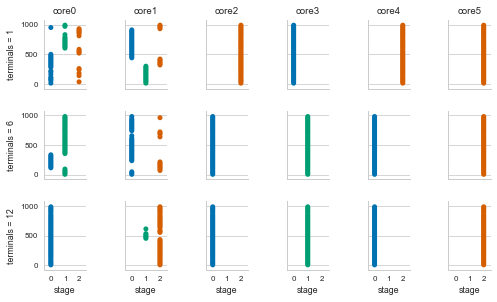

In [34]:
df = get_result('assignment_traces')
# get perspective that we need: cores by core_stage
t = df.groupby(['build', 'maa', 'threads', 'time', 'core', 'core_stage']).first().reset_index(['threads', 'time', 'core', 'core_stage'])
# limit to what we want to present
t = t.query('build == "cinrunq3" & maa == 20000000 & threads in [1,6,12] ').reset_index(['build', 'maa'], drop=True)

t['time'] = t['time'] / 1000 # normalize to milliseconds
t = t.loc[(t['time'] >= trace_begin) &  (t['time'] <= trace_end)]
t['time'] -= trace_begin

g = sns.factorplot(kind='strip', col='core', row='threads', x='core_stage', y='time', hue='core_stage',
                    aspect=0.8, size=1.5, jitter=False, data=t, legend=False)
# plt.suptitle("Core Assignment over Time")
plt.subplots_adjust(top=0.88)
# g.fig.legend(t['core_stage'].map(lambda x: "Stage {}".format(x)).unique(), loc='lower center', ncol=3)

plottedthreads = sorted(t['threads'].unique())
plottedcores = sorted(t['core'].unique())
for row, threads in enumerate(plottedthreads):
    for col, core in enumerate(plottedcores):
        ax = g.axes[row, col]
        if col == 0:
            ax.set_ylabel('terminals = {}'.format(threads))
        else:
            ax.set_ylabel('')
        
        if row == 0:
            ax.set_title('core{}'.format(core))
        else:
            ax.set_title('')
        
        if row == len(plottedthreads)-1:
            ax.set_xlabel('stage')
    
#         g.set_xlabels(x_var=list(map(lambda x: "Core {}".format(x), )
savefig('cap_assignments_by_core')

#### Core Allocation Policy Assigns Cores Based on Stage Load

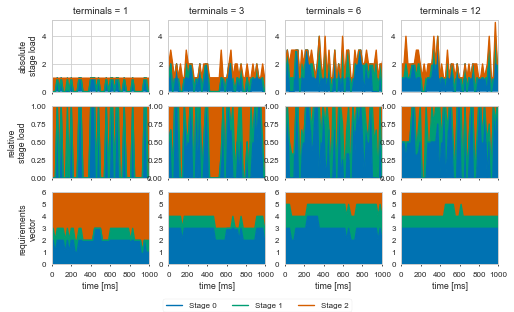

In [35]:
df = get_result('assignment_traces')
# remove the unused stage and stage_load
df = df.groupby(['build', 'maa', 'threads', 'time', 'core_stage', 'core']).first().reset_index("core")[["core"]]
# core assignment to stage is core count per stage
df = df.groupby(df.index.names).count().unstack()
df.columns = df.columns.droplevel(0)
df = df.rename(lambda x: 'cores assigned to stage{}'.format(x), axis=1)
core_assignment = df

df = get_result('assignment_traces')
# remove the unused core and core_assignment
df = df.groupby(['build', 'maa', 'threads', 'time', 'stage', 'stage_load']).first().reset_index(['stage_load'])[['stage_load']]
df = df.unstack()
df.columns = df.columns.droplevel(0)
df = df.rename(lambda x: 'load of stage{}'.format(x), axis=1)
stage_load = df

sum_load_col = stage_load.sum(axis=1)
rel_stage_load = stage_load.apply(lambda abscol: abscol.div(sum_load_col))

p = pd.concat([stage_load, rel_stage_load, core_assignment], axis=1)

threads = [1, 3, 6, 12]
fig, ax = plt.subplots(nrows=3, ncols=len(threads), figsize=(8, 4.5))
for j, r in enumerate(["absolute\nstage load", "relative\nstage load", "requirements\nvector"]):
    ax[j, 0].set_ylabel(r)
    for i, t in enumerate(threads):
        pcol = p.take(range(j*3, j*3+3), axis=1)
        pcol = pcol.query('build == "cinrunq3" & maa == 20000000').reset_index(['build', 'maa'], drop=True)
        pcol = pcol.reset_index('time').loc[t].reset_index('threads', drop=True) # select thread count
        pcol['time'] /= 1000 # normalize to milliseconds
        pcol['time'] -= trace_begin
        pcol = pcol.set_index('time')
        pcol.plot.area(use_index=True, ax=ax[j, i], legend=False, stacked=True)
        if j == 0:
            ax[j, i].set_title('terminals = {}'.format(t))
        # units: milliseconds
        steps = 20
        majorevery = 10
        duration=trace_end-trace_begin
        minorsteps = np.arange(0, duration+steps, steps)
        majorsteps = np.arange(0, duration+steps*majorevery, steps*majorevery)
        ax[j, i].set_xlim(0, duration)
        ax[j, i].set_xticks(minorsteps, minor=True)
        ax[j, i].set_xticks(majorsteps, minor=False)
        ax[j, i].tick_params(axis='x', which='major', direction='inout', length=4)
        ax[j, i].set_xlabel("")
        ax[j, i].set_xticklabels([])
        if j == 0:
            ax[j, i].set_ylim(0, 5.2)
        if j == 1:
            ax[j, i].set_ylim(0, 1)
        if j == 2:
            ax[j, i].set_xticklabels(majorsteps)
            ax[j, i].set_ylim(0, 6)
            ax[j, i].set_yticks(np.arange(0, 7, 1))
            ax[j, i].set_xlabel('time [ms]')
            
        ax[j, i].grid(True)

fig.legend(stage_load.columns.map(lambda x: "Stage " + re.match(r'^.* stage(\d+)$', x)[1]),
           loc='lower center', ncol=len(pcol.columns), borderaxespad=0)
# fig.suptitle("Stage Load and Resulting Requirements Vector")
# fig.subplots_adjust(top=1.2)
savefig('cap_assignment_by_stage_load')
plt.show()

###  Performance Evaluation

In [36]:
df = get_result("3way")

sel = [
#     ("linuxvm", "Linux VM"),
#     ("upstream_nospin0_ies1","Upstream OSv"),
#     ("upstream_nospin1_ies2","Upstream OSv (MWAIT)"),
#     ("upstream_nospin0_ies0","Upstream OSv (busy)"),
    ("mine_cinrunq3_mwait1_maa20000000", "CAP|MWAIT"),
    ("mineFixed2C_mwait1", "Fixed|MWAIT"),
    ("mine_cinrunq3_mwait0_maa20000000","CAP|busy"),
    ("mineFixed2C_mwait0", "Fixed|busy"),
    # use the following to show that assignment_age has no impact
#     ("mine_cinrunq3_mwait0_maa10000000","Our solution 1 (busy)"),
#     ("mine_cinrunq3_mwait0_maa50000000","Our solution 5 (busy)"),

#     "mine_cinall_mwait1_maa50000000":"3.2.3 Our solution (CAP cinall, MWAIT)",
#     "mine_cinall_mwait0_maa50000000":"3.2.4 Our solution (CAP cinall, busy)",

]

p = df.reset_index().set_index('build').loc[map(lambda x: x[0], sel)].rename(dict(sel)).reset_index()
cols = p['build'].str.split('|', expand=True).rename({0:"Allocation", 1:"Idle Strategy"}, axis=1)
p = pd.concat([p, cols], axis=1)
cache['cap_perf'] = p

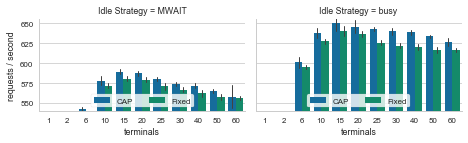

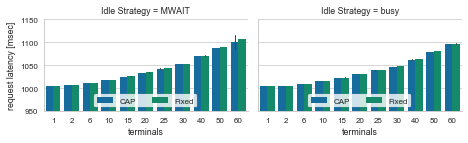

In [37]:
p = get_result('cap_perf')
g = sns.factorplot(legend=False, kind='bar', col='Idle Strategy', x='threads', y='tpcc_throughput', hue='Allocation',
                   ci='sd', errwidth=1, aspect=1.5, size=2.2, data=p)
# g.fig.suptitle('Core Allocation Policy vs. Fixed Allocation -- Throughput')
g.set_axis_labels('terminals', 'requests / second')
plt.subplots_adjust(top=0.8)
for i in [0, 1]:
    g.axes[0, i].legend(loc='lower center', ncol=2)    
    g.axes[0, i].set_ylim(540, 655)
savefig('cap_perf_throughput')
plt.show()

p = get_result('cap_perf')
g = sns.factorplot(legend=False, kind='bar', col='Idle Strategy', x='threads', y='tpcc_avg_lat', hue='Allocation',
                   ci='sd', errwidth=1, aspect=1.5, size=2.2, data=p)
# g.fig.suptitle('Core Allocation Policy vs. Fixed Allocation -- Request Latency')
g.set_axis_labels('terminals', 'request latency [msec]')
plt.subplots_adjust(top=0.8)
for i in [0, 1]:
    g.axes[0, i].legend(loc='lower center', ncol=2)
    g.axes[0, i].set_ylim(950, 1150)
savefig('cap_perf_reqlat')
plt.show()

### Speedup Due to CAP

In [38]:
p = get_result('cap_perf')
p = p.groupby(['Allocation', 'threads', 'Idle Strategy']).mean()
p = p.reset_index()
colmap = {
    'Allocation':'Allocation',
    'Idle Strategy':'Idle Strategy',
    'threads':'Terminals',
    'tpcc_throughput':'TPC-C Throughput',
    'tpcc_avg_lat':'TPC-C Request Latency',
    'l2_rqsts.code_rd_miss/tpcc_throughput':"L2 code misses / request",
    'l2_rqsts.data_misses_interp/tpcc_throughput':"L2 data misses / request",
#     'l2_rqsts.miss/tpcc_throughput':"L2 misses / request",
#      'l2_rqsts.references/tpcc_throughput':"L2 references",
}
p = p[list(colmap.keys())]
p = p.rename(colmap, axis=1)
p = p.set_index(['Allocation', 'Terminals', 'Idle Strategy'])
p = p.unstack()
cap = p.query('Allocation == "CAP"').reset_index('Allocation', drop=True)
fixed = p.query('Allocation == "Fixed"').reset_index('Allocation', drop=True)
speedup = (cap/fixed).transpose().round(2)
speedup.to_latex('processed/cap_per_speedup.tex')
speedup

Terminals                                 1     2     6     10    15    20  \
                         Idle Strategy                                       
TPC-C Throughput         MWAIT          0.98  0.98  1.01  1.01  1.02  1.01   
                         busy           0.98  0.98  1.01  1.02  1.01  1.01   
TPC-C Request Latency    MWAIT          1.00  1.00  1.00  1.00  1.00  1.00   
                         busy           1.00  1.00  1.00  1.00  1.00  1.00   
L2 code misses / request MWAIT          1.00  0.96  0.97  0.99  0.97  1.00   
                         busy           0.97  0.96  0.96  0.99  0.99  0.98   
L2 data misses / request MWAIT          1.03  1.01  1.01  1.00  1.01  1.02   
                         busy           1.05  1.01  1.01  0.99  0.98  1.01   

Terminals                                 25    30    40    50    60  
                         Idle Strategy                                
TPC-C Throughput         MWAIT          1.02  1.01  1.02  1.01  1.00  
                         busy           1.03  1.03  1.03  1.03  1.02  
TPC-C Request Latency    MWAIT          1.00  1.00  1.00  1.00  0.99  
                         busy           1.00  1.00  1.00  1.00  1.00  
L2 code misses / request MWAIT          1.00  0.99  0.97  0.96  1.00  
                         busy           0.98  0.95  0.98  1.00  0.97  
L2 data misses / request MWAIT          1.01  1.01  1.02  1.01  1.01  
                         busy           1.01  1.01  1.02  1.02  1.00

# Blurp 

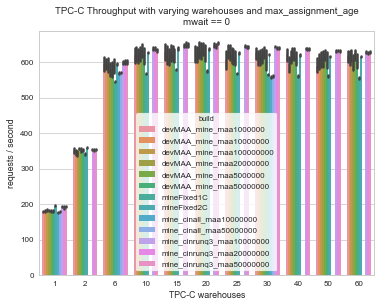

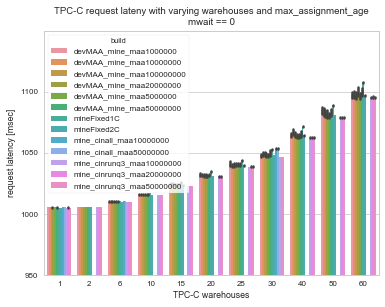

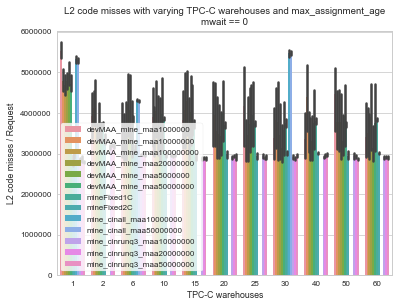

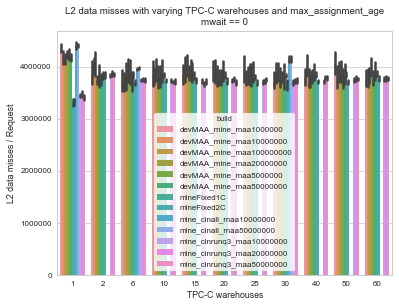

In [39]:
df = get_result("cap")
q = "mwait == 0"
p = df.query(q).reset_index()
fig, ax = plt.subplots()
sns.barplot(x='threads', y='tpcc_throughput', hue='build', data=p)
ax.set_title('TPC-C Throughput with varying warehouses and max_assignment_age\n' + q)
ax.set_xlabel('TPC-C warehouses')
ax.set_ylabel('requests / second')
plt.show()

fig, ax = plt.subplots()
sns.barplot(x='threads', y='tpcc_avg_lat', hue='build', data=p)
ax.set_title('TPC-C request lateny with varying warehouses and max_assignment_age\n' + q)
ax.set_xlabel('TPC-C warehouses')
ax.set_ylabel('request latency [msec]')
ax.set_ylim(950, 1150)
ax.set_yticks(np.arange(950, 1150, 50))
plt.show()

fig, ax = plt.subplots()
sns.barplot(x='threads', y='l2_rqsts.code_rd_miss/tpcc_throughput', hue='build', data=p)
ax.set_title('L2 code misses with varying TPC-C warehouses and max_assignment_age\n' + q)
ax.set_xlabel('TPC-C warehouses')
ax.set_ylabel('L2 code misses / Request')
ax.legend(loc='lower left')
plt.show()

fig, ax = plt.subplots()
ax = sns.barplot(x='threads', y='l2_rqsts.data_misses_interp/tpcc_throughput', hue='build', data=p)
ax.set_title('L2 data misses with varying TPC-C warehouses and max_assignment_age\n' + q)
ax.set_xlabel('TPC-C warehouses')
ax.set_ylabel('L2 data misses / Request')
plt.show()

# Comparison Ours vs. Upstream OSv 

This section provides proof for the claims made for individual design decisions.

## Our Solution Outperforms Upstream OSv

This was already shown in the 3-way comparison

## Fast Thread Migration Is Required

TODO

Use Stagified Upstream API, should be fair to just add the API but still consider it upstream.

## Performance Difference Due To MWAIT in idle thread

## Core Allocation Policy


In [40]:
df = get_result("ours_vs_upstream")

q = "mwait == 0"
p = df.query(q).reset_index()
fig, ax = plt.subplots()
sns.barplot(x='threads', y='tpcc_throughput', hue='build', data=p)
ax.set_title('TPC-C Throughput with varying warehouses and max_assignment_age\n' + q)
ax.set_xlabel('TPC-C warehouses')
ax.set_ylabel('requests / second')
#ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

KeyError: 'ours_vs_upstream'

### CAP allocates cores proportional to stage load

### CAP improves performance

In [ ]:
df = get_result("ours_vs_upstream")
q = "mwait == 0"
p = df.query(q).reset_index()
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='threads', y='tpcc_avg_lat', hue='build', data=p)
ax.set_title('TPC-C request latency with varying warehouses and max_assignment_age\nAttention: Offset in Y Axis\n' + q)
ax.set_xlabel('TPC-C warehouses')
ax.set_ylabel('request latency [msec]')
ax.set_ylim(950, 1150)
ax.set_yticks(np.arange(950, 1150, 50))
plt.show()